In [3]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2

In [4]:
def draw_multiline_text(text, size=(800, 600), font='arial', show=False):
    offset_x = size[0] // 5
    offset_y = size[1] // 5
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    l = 5
    r = 100
    while l <= r:
        s = (l + r) // 2
        fnt = ImageFont.truetype(f"fonts/{font}.ttf", s)
        upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
        if (upper_x > offset_x and lower_x < size[0] - offset_x
            and upper_y > offset_y and lower_y < size[1] - offset_y):
            l = s + 1
        else:
            r = s - 1


    font_size = r
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

In [21]:
def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if show:
        display(img)
    return img

In [22]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

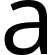

In [23]:
char_a = draw_single_character('a', 99, font='open-sans')
display(char_a)

In [65]:
out, f_size = draw_multiline_text('the quick brown fox!,\njumps over the lazy dog\nthe quick brown fox!,\njumps over the lazy dog\nthe quick brown fox!,\nthe quick brown fox!,\njumps over the lazy dog', font='open-sans')
# display(out)
# out = rotate_image(out, 30)
# display(out)
# out = rotate_image(out, -30)
# display(out)

In [66]:
def get_all_character(font, fontsize):
    characters = string.ascii_lowercase + ".,?!"
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))


In [67]:
def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img)

def matrix_to_image(matrix):
    return Image.fromarray(matrix)

def invert_colors(matrix):
    return 255 - matrix

def convolve_images(pattern, image):
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=image.shape) * fft2(image)))



In [70]:
def ocr(image, font, font_size, i=11):
    chars = get_all_character(font, font_size)
    char_arrays = list(map(img_to_matrix, chars))
    char_arrays = list(map(invert_colors, char_arrays))

    matrix = img_to_matrix(image)
    matrix = invert_colors(matrix)

    convolution = convolve_images(char_arrays[i], matrix)
    max_correlation = np.max(convolve_images(char_arrays[i], char_arrays[i]))

    display(Image.fromarray(char_arrays[i]))

    new_array = np.array(image.convert('RGB'))
    a, b = char_arrays[i].shape
    red = (255, 0, 0)

    count = 0
    for i, j in zip(*np.where((convolution > 0.9999 * max_correlation) & (convolution <= 1.0001*max_correlation))):
        new_array[i:i-a:-1, j] = red
        new_array[i:i-a:-1, j - b] = red
        new_array[i, j:j-b:-1] = red
        new_array[i - a, j:j-b:-1] = red
        count += 1

    display(Image.fromarray(new_array))


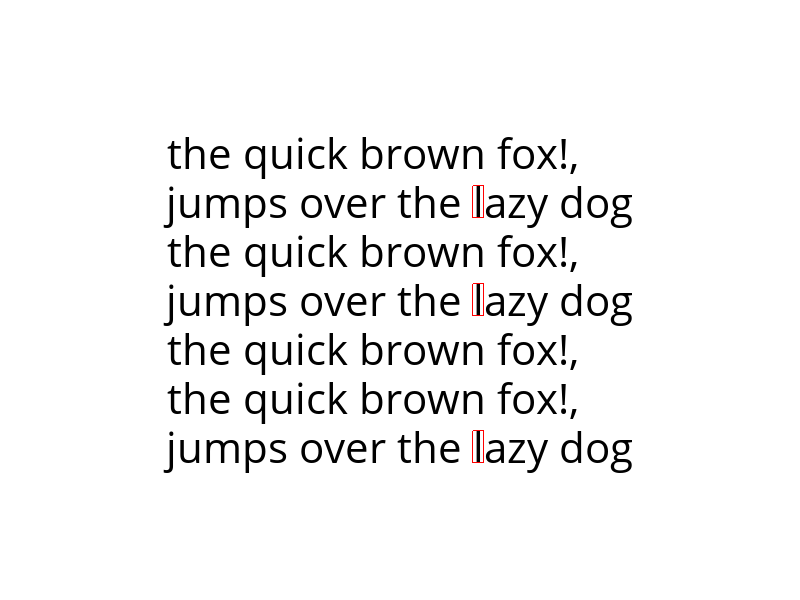

In [71]:
ocr(out, 'open-sans', f_size)